## **Start running RolLbl2**

In [ ]:
import os
import sys
import gc
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.options.display.max_rows = None
pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=np.inf)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)

###Start sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split,TimeSeriesSplit,cross_val_score,KFold,cross_validate,GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix
### End sklearn

###***Start tensorflow.keras
import tensorflow as tf
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(1234)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
###**** End tensorflow.keras
#sys.path.append("..")

import sys
from pathlib import Path
pathAug = "/content/drive/MyDrive/MasterThesis_Files/mainCodes/augmentation/"
pathData ="/content/drive/MyDrive/MasterThesis_Files/mainCodes/data/forCrossValidation/Shifted5_Rol_Lbl2/"



sys.path.insert(0,pathAug)
sys.path.insert(1,pathData)

import preprocessRollingLabel2_NN as aug

#####End Import Libraries

In [ ]:

############ Start Running codes

datestr = time.strftime("%y%m%d_%H%M%S")
print(f"Main Start running time : {datestr}")

#dfActual = pd.read_csv(pathData+"Shifted5_NoLess5_AfterRol_Lbl2_5To1_210124_163135.csv",header=None)
dfActual = pd.read_csv(pathData+"Shifted5_NoLess5_AfterRol_Lbl2_210124_155122.csv",header=None)


accPerFold = []
lossPerFold = []
dfPrReF1=pd.DataFrame()

#dfActual=dfActual[:5000]

yX=dfActual.values
X = yX[:, 1:]  # converts the df to a numpy array
y = yX[:, 0]

print(f"\n Number of Actual labeled 0: {len(y[np.where(y==0)])}")
print(f"Number of Actual labeled 1: {len(y[np.where(y==1)])}")
print(f"Number of Actual labeled 2: {len(y[np.where(y==2)])} \n")


dataSplitPCT=.3
dataSplitValTestPCT=.5

train_test_split_Shuffle=True
flagFitShuffle = True
flagSeed=True

p1=""

skf = StratifiedKFold(n_splits=5,shuffle=True)#5
model=0

for foldNum, (trainIndex, testIndex) in enumerate(skf.split(X,y),start=1):

    #print("TRAIN:", trainIndex, "TEST:", testIndex)

    yXtrain, yXtest = yX[trainIndex], yX[testIndex]
    #ytrain, ytest = y[trainIndex], y[testIndex]

    AugedNN=aug.GenerateAug_NN_Rolling(yXtrain,foldNum,flagLbl2=False,jitterNum4Lbl1=3,jitterNum4Lbl2=29)###***Generate synthetic data 38

    datestrfoldNum = time.strftime("%y%m%d_%H%M%S")
    print(f"\n Start running time Fold={foldNum}: {datestrfoldNum} ,-------------------------- \n")

    Actual_AugedNN=np.concatenate((yXtrain,AugedNN),axis=0)

    yXtrain1, yXtrain2 = train_test_split(Actual_AugedNN, shuffle=train_test_split_Shuffle,
                                                          test_size=dataSplitPCT, random_state=42,
                                                          stratify=Actual_AugedNN[:,0])  # stratify=input_y

    yXtrain = np.concatenate((yXtrain1, yXtrain2), axis=0)

    yXvalid, yXtest = train_test_split(yXtest, shuffle=train_test_split_Shuffle,
                                          test_size=dataSplitValTestPCT, random_state=42,
                                          stratify=yXtest[:, 0])  # stratify=input_y

    print(f"\n Number of Final yXtrain_Fold={foldNum} labeled 0: {len(yXtrain[np.where(yXtrain[:, 0] == 0)])}")
    print(f"Number of Final yXtrain_Fold={foldNum} labeled 1: {len(yXtrain[np.where(yXtrain[:, 0] == 1)])}")
    print(f"Number of Final yXtrain_Fold={foldNum} labeled 2: {len(yXtrain[np.where(yXtrain[:, 0] == 2)])} \n")

    ytrain = to_categorical(yXtrain  [:,0] )
    yvalid = to_categorical(yXvalid  [:,0] )
    ytest  = to_categorical(yXtest   [:,0] )

    xtrain = yXtrain  [:,1:]
    xvalid = yXvalid  [:,1:]
    xtest  = yXtest   [:,1:]


    neurons = xtrain.shape[1]

    epochs = 100#100#0#30#30# 150  # 0  # 100#300#60#300#10#200#00#150
    batch = 32
    lr = 0.0001

    #flagR1 = True
    flagR1=False
    r1 = .1
    r2 = .3
    d1 = .3

    if foldNum==1:
        print("\n Hyperparameters:")
        print(f"epochs: {epochs}, batch: {batch}, lr: {lr}, neurons: {neurons}, flagFitShuffle: {flagFitShuffle} , train_test_split_Shuffle: {train_test_split_Shuffle}, flagSeed: {flagSeed}\n ")

        print(f"\n xtrain: {np.shape(xtrain)}, ytrain: {np.shape(ytrain)}")
        print(f"xvalid: {np.shape(xvalid)}, yvalid: {np.shape(yvalid)}")
        print(f"xtest: {np.shape(xtest)}, ytest: {np.shape(ytest)} \n")

        #p1 = os.path.join(str(pathCurrent.parent.parent), "Results", "Results_001_class_oppys", "bestModels", "")
        # pathSavingPlotsPerRunning = pathSavingPlots + datestr #+ "_" + modelname
        # if not os.path.exists(pathSavingPlotsPerRunning):
        #     os.makedirs(pathSavingPlotsPerRunning)


    del model
    gc.collect()
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    model = Sequential()
    model.add(Dense(177, activation='tanh', input_dim=xtrain.shape[1]
                    #,kernel_regularizer=l1_l2(l1=r1, l2=r2)
                    #,kernel_regularizer = l1(r1) if flagR1 else l2(r2),
                    ))  # , input_dim=xtrain.shape[1]
    #model.add(Dropout(d1))

    model.add(Dense(150, activation='tanh'
                    #,kernel_regularizer=l1(r1) if flagR1 else l2(r2)
                    #,kernel_regularizer=l1_l2(l1=r1, l2=r2)
                    # bias_regularizer=l1(r2),
                    #activity_regularizer=l1(r1) if flagR1 else l2(r2)
                    # activity_regularizer=l1(r2)
                    ))
    #model.add(Dropout(d1))

    model.add(Dense(90, activation='tanh'
                    #,kernel_regularizer=l1(r1) if flagR1 else l2(r2)
                    #,kernel_regularizer=l1_l2(l1=r1, l2=r2)
                    # bias_regularizer=l1(r2),
                    #activity_regularizer = l1(r1) if flagR1 else l2(r2)
                    # activity_regularizer=l2(r2)
                    ))
    #model.add(Dropout(d1))

    # model.add(Dense(295, activation='tanh'
    #                 #kernel_regularizer=l1(r1) if flagR1 else l2(r2),
    # #                 # bias_regularizer=l1(r2),
    # #                 activity_regularizer=l1(r1) if flagR1 else l2(r2)
    # #                 # activity_regularizer=l2(r2)
    #                 ))
    #model.add(Dropout(d1))

    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))

    adam = optimizers.Adam(lr)#lr
    # cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",save_best_only=True,verbose=0)
    # model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    # es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

    if foldNum == 1:
        print("\n Final test model.summary(): \n")
        print(model.summary())

        print(f"\n model.get_config: {str(model.get_config())}")

    # fit model
    history1 = model.fit(xtrain, ytrain, batch_size=batch, epochs=epochs
                         , validation_data=(xvalid, yvalid)
                         , verbose=1, use_multiprocessing=True,
                         shuffle=flagFitShuffle).history  # ,shuffle=True#,callbacks=[es]

    plt.figure()
    plt.plot(history1['loss'], linewidth=2, label='Train')  # OR accuracy
    plt.plot(history1['val_loss'], linewidth=2, label='Validation')  # OR val_accuracy
    plt.legend(loc='upper right', bbox_to_anchor=(1.13, 1.13))
    plt.title(f'Model loss Fold={foldNum}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0,.5)
    #plt.savefig(pathSavingPlotsPerRunning +"/" + f"loss&val_loss_Fold={foldNum}_Epochs{epochs}_flagSeed{flagSeed}.png", dpi=300, format='png')
    plt.show()

    yPred = model.predict(xtest, verbose=1)

    print(f"confusion_matrix_Fold={foldNum}:\n {confusion_matrix(ytest.argmax(axis=1), yPred.argmax(axis=1))} \n")

    # Creating multilabel confusion matrix
    mlbConfusion = multilabel_confusion_matrix(ytest.argmax(axis=1), yPred.argmax(axis=1))
    print(f"multilabel_confusion_matrix_Fold={foldNum}:\n {mlbConfusion} \n")

    print(f"accuracy_score_Fold={foldNum}:\n {accuracy_score(ytest.argmax(axis=1), yPred.argmax(axis=1), normalize=False)} \n")

    print(f"classification_report_Fold={foldNum}:\n {classification_report(ytest.argmax(axis=1), yPred.argmax(axis=1))} \n")

    cr=pd.DataFrame(classification_report(ytest.argmax(axis=1), yPred.argmax(axis=1),output_dict=True))
    dfPrReF1=dfPrReF1.append(cr.iloc[:3,:3])

    # Predicting test images
    # preds = np.where(yPred < 0.5, 0, 1)

    mlbClasses = [0, 1, 2]
    # Plot confusion matrix
    plt.figure(figsize=(14, 8))
    for j, (label, matrix) in enumerate(zip(mlbClasses, mlbConfusion)):
        plt.subplot(f'23{j + 1}')
        labels = [f'Not_{label}', label]
        sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues',
                    cbar_kws={'label': 'My Colorbar'},  # , fmt = 'd'
                    xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1)

        plt.ylabel('Actual class')
        plt.xlabel(f'Predicted class_Fold={foldNum}')
        plt.title(labels[0])

    plt.tight_layout()
    #plt.savefig(pathSavingPlotsPerRunning +"/" + f"ConfusionMatrix_Fold={foldNum}_Epochs{epochs}_flagSeed{flagSeed}.png", dpi=300, format='png')
    plt.show()

    datestr = time.strftime("%y%m%d_%H%M%S")
    print(f"End running time Fold={foldNum}: {datestr} ,-------------------------- \n")

dfPrReF1=pd.DataFrame([np.round(dfPrReF1[dfPrReF1.index=='precision'].mean(),2),np.round(dfPrReF1[dfPrReF1.index=='recall'].mean(),2)
,np.round(dfPrReF1[dfPrReF1.index=='f1-score'].mean(),2)],index=['precision','recall','f1-score'])

print(f"\nclassification_report_AllFolds:\n {dfPrReF1}")

datestr = time.strftime("%y%m%d_%H%M%S")
print(f"End running time: {datestr}")


# End running  RolLbl2

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

## **forAugShifted5**

Main Start running time : 210214_085547

 Number of Actual labeled 0: 87245
Number of Actual labeled 1: 2870
Number of Actual labeled 2: 0 

Start running time Data Augmentation_Fold=1: 210214_085548 ,-------------------------- 


 Data Augmentation Hyperparameters:
epochs: 2000, batch: 32, lr: 0.0001, neurons1: 177, neurons2: 150, flagFitShuffle: True 
 

 Hyperparameters:

 Data Augmentation model.summary(): 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 177)               10620     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               26700     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                13590     
_________________________________________________________________
dense_3 (Dense)              (None, 

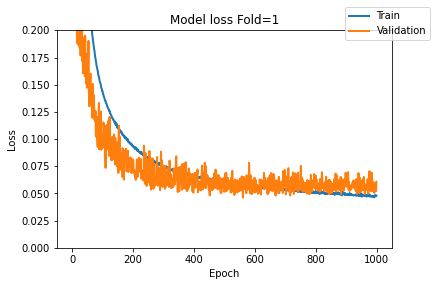

282/282 [==============================] - 0s 940us/step
xtrain: (85868, 59), ytrain: (85868,)
xvalid: (9011, 59), yvalid: (9011,)
xtest: (9012, 59), ytest: (9012,)

classification_report_Fold=1:
              precision    recall  f1-score   support

    Normal 0       1.00      0.98      0.99      8725
 Anomalous 1       0.59      0.87      0.71       287

    accuracy                           0.98      9012
   macro avg       0.79      0.93      0.85      9012
weighted avg       0.98      0.98      0.98      9012

confusion_matrix_Fold=1:

True Negatives:  8553
False Positives:  172
False Negatives:  36
True Positives:  251
accuracy_score_Fold=1:
 8804 

End running time Fold=1: 210214_092303 ,-------------------------- 

Start running time Data Augmentation_Fold=2: 210214_092303 ,-------------------------- 

Data Augmentation MSE Label1, iter2==> mean: 1.110064921240261e-05, min: 3.897988961917731e-06, max: 0.0002312187141438627
End running time Data Augmentation_Fold=2: 210214_094

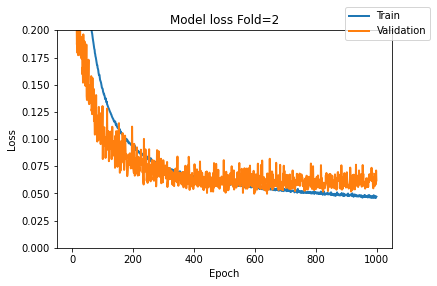

282/282 [==============================] - 0s 996us/step
xtrain: (85868, 59), ytrain: (85868,)
xvalid: (9011, 59), yvalid: (9011,)
xtest: (9012, 59), ytest: (9012,)

classification_report_Fold=2:
              precision    recall  f1-score   support

    Normal 0       1.00      0.98      0.99      8725
 Anomalous 1       0.58      0.88      0.70       287

    accuracy                           0.98      9012
   macro avg       0.79      0.93      0.84      9012
weighted avg       0.98      0.98      0.98      9012

confusion_matrix_Fold=2:

True Negatives:  8540
False Positives:  185
False Negatives:  35
True Positives:  252
accuracy_score_Fold=2:
 8792 

End running time Fold=2: 210214_095011 ,-------------------------- 

Start running time Data Augmentation_Fold=3: 210214_095011 ,-------------------------- 

Data Augmentation MSE Label1, iter2==> mean: 1.0324411145373457e-05, min: 2.940464134534943e-06, max: 0.00013972056179266794
End running time Data Augmentation_Fold=3: 210214_1

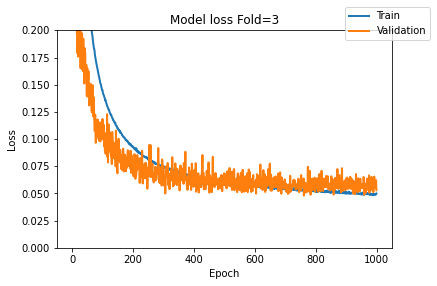

282/282 [==============================] - 0s 970us/step
xtrain: (85868, 59), ytrain: (85868,)
xvalid: (9011, 59), yvalid: (9011,)
xtest: (9012, 59), ytest: (9012,)

classification_report_Fold=3:
              precision    recall  f1-score   support

    Normal 0       0.99      0.98      0.99      8725
 Anomalous 1       0.63      0.83      0.72       287

    accuracy                           0.98      9012
   macro avg       0.81      0.91      0.85      9012
weighted avg       0.98      0.98      0.98      9012

confusion_matrix_Fold=3:

True Negatives:  8585
False Positives:  140
False Negatives:  49
True Positives:  238
accuracy_score_Fold=3:
 8823 

End running time Fold=3: 210214_101717 ,-------------------------- 

Start running time Data Augmentation_Fold=4: 210214_101717 ,-------------------------- 

Data Augmentation MSE Label1, iter2==> mean: 1.1209774885741043e-05, min: 2.6535811163314677e-06, max: 0.0002376395609542478
End running time Data Augmentation_Fold=4: 210214_1

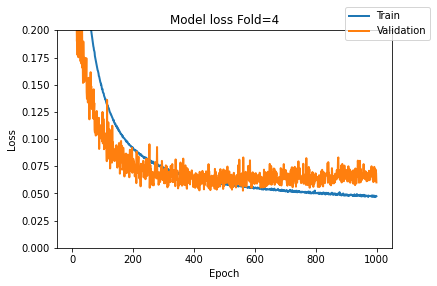

282/282 [==============================] - 0s 966us/step
xtrain: (85868, 59), ytrain: (85868,)
xvalid: (9011, 59), yvalid: (9011,)
xtest: (9012, 59), ytest: (9012,)

classification_report_Fold=4:
              precision    recall  f1-score   support

    Normal 0       0.99      0.98      0.99      8725
 Anomalous 1       0.59      0.74      0.65       287

    accuracy                           0.98      9012
   macro avg       0.79      0.86      0.82      9012
weighted avg       0.98      0.98      0.98      9012

confusion_matrix_Fold=4:

True Negatives:  8574
False Positives:  151
False Negatives:  74
True Positives:  213
accuracy_score_Fold=4:
 8787 

End running time Fold=4: 210214_104438 ,-------------------------- 

Start running time Data Augmentation_Fold=5: 210214_104438 ,-------------------------- 

Data Augmentation MSE Label1, iter2==> mean: 1.168529122596383e-05, min: 3.0825261039666358e-06, max: 0.00021248865851291224
End running time Data Augmentation_Fold=5: 210214_1

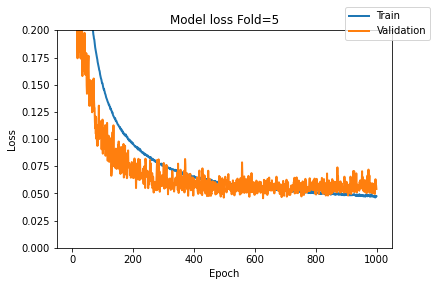

282/282 [==============================] - 0s 962us/step
xtrain: (85868, 59), ytrain: (85868,)
xvalid: (9011, 59), yvalid: (9011,)
xtest: (9012, 59), ytest: (9012,)

classification_report_Fold=5:
              precision    recall  f1-score   support

    Normal 0       0.99      0.98      0.99      8725
 Anomalous 1       0.58      0.82      0.68       287

    accuracy                           0.98      9012
   macro avg       0.79      0.90      0.83      9012
weighted avg       0.98      0.98      0.98      9012

confusion_matrix_Fold=5:

True Negatives:  8558
False Positives:  167
False Negatives:  53
True Positives:  234
accuracy_score_Fold=5:
 8792 

End running time Fold=5: 210214_111150 ,-------------------------- 


classification_report_AllFolds:
            Normal 0  Anomalous 1
precision      0.99         0.59
recall         0.98         0.83
f1-score       0.99         0.69
End running time: 210214_111150


In [2]:
import os
import sys
import gc
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.options.display.max_rows = None
pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=np.inf)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)

###Start sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split,TimeSeriesSplit,cross_val_score,KFold,cross_validate,GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix
### End sklearn

###***Start tensorflow.keras
import tensorflow as tf
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(1234)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
###**** End tensorflow.keras
#sys.path.append("..")
import sys
from pathlib import Path

pathAug = "/content/drive/MyDrive/MasterThesis_Files/mainCodes/augmentation/"
#pathData ="/content/drive/MyDrive/MasterThesis_Files/mainCodes/data/forCrossValidation/forAugShifted5/"
pathData ="/content/drive/MyDrive/MasterThesis_Files/mainCodes/data/forCrossValidation/Shifted5_Rol_Lbl1/"


sys.path.insert(0,pathAug)
sys.path.insert(1,pathData)

import preprocessRollingLabel2_NN as aug


#####End Import Libraries


############ Start Running codes

datestr = time.strftime("%y%m%d_%H%M%S")
print(f"Main Start running time : {datestr}")

accPerFold = []
lossPerFold = []
dfPrReF1=pd.DataFrame()


# dfActual = pd.read_csv(pathData+"dfpShifted5_ForAug_201201_202734_AllTested_Correct_NT_NH.csv",header=None)
#dfActual = pd.read_csv(pathData+"dfpShifted5ForAug_1To5_FromAllTrainTest_201204_192153.csv",header=None)
dfActual = pd.read_csv(pathData+"dfpShifted5_Rolling_210110_191921.csv",header=None)



#dfActual=dfActual[:5000]

yX=dfActual.values
X = yX[:, 1:]  # converts the df to a numpy array
y = yX[:, 0]

print(f"\n Number of Actual labeled 0: {len(y[np.where(y==0)])}")
print(f"Number of Actual labeled 1: {len(y[np.where(y==1)])}")
print(f"Number of Actual labeled 2: {len(y[np.where(y==2)])} \n")


dataSplitPCT=.3
dataSplitValTestPCT=.5

train_test_split_Shuffle=True
flagFitShuffle = True#False
flagSeed=True

p1=""

skf = StratifiedKFold(n_splits=5,shuffle=True)#5
# skf = KFold(n_splits=5,shuffle=False)#5
model=0

for foldNum, (trainIndex, testIndex) in enumerate(skf.split(X,y),start=1):

    #print("TRAIN:", trainIndex, "TEST:", testIndex)

    yXtrain, yXtest = yX[trainIndex], yX[testIndex]
    #ytrain, ytest = y[trainIndex], y[testIndex]

    AugedNN=aug.GenerateAug_NN_Rolling(yXtrain,foldNum,flagLbl2=False,jitterNum4Lbl1=7,jitterNum4Lbl2=3)###***Generate synthetic data

    datestrfoldNum = time.strftime("%y%m%d_%H%M%S")
    print(f"\n Start running time Fold={foldNum}: {datestrfoldNum} ,-------------------------- \n")

    Actual_AugedNN=np.concatenate((yXtrain,AugedNN),axis=0)
    #yXtrain=Actual_AugedNN

    yXtrain1, yXtrain2 = train_test_split(Actual_AugedNN, shuffle=train_test_split_Shuffle,
                                                          test_size=dataSplitPCT, random_state=42,
                                                          stratify=Actual_AugedNN[:,0])  # stratify=input_y

    yXtrain = np.concatenate((yXtrain1, yXtrain2), axis=0)

    yXvalid, yXtest = train_test_split(yXtest, shuffle=train_test_split_Shuffle,
                                          test_size=dataSplitValTestPCT, random_state=42,
                                          stratify=yXtest[:, 0])  # stratify=input_y

    print(f"\n Number of Final yXtrain_Fold={foldNum} labeled 0: {len(yXtrain[np.where(yXtrain[:, 0] == 0)])}")
    print(f"Number of Final yXtrain_Fold={foldNum} labeled 1: {len(yXtrain[np.where(yXtrain[:, 0] == 1)])}")
    print(f"Number of Final yXtrain_Fold={foldNum} labeled 2: {len(yXtrain[np.where(yXtrain[:, 0] == 2)])} \n")

    ytrain = yXtrain  [:,0]
    yvalid = yXvalid  [:,0]
    ytest  = yXtest   [:,0]

    xtrain = yXtrain  [:,1:]
    xvalid = yXvalid  [:,1:]
    xtest  = yXtest   [:,1:]


    neurons = xtrain.shape[1]

    epochs = 1000#50#40#60#30#30# 150  # 0  # 100#300#60#300#10#200#00#150
    batch = 512#32
    lr = 0.0001

    #flagR1 = True
    flagR1=False
    r1 = .1
    r2 = .1
    d1 = .2

    if foldNum==1:
        print("\n Hyperparameters:")
        print(f"epochs: {epochs}, batch: {batch}, lr: {lr}, neurons: {neurons}, flagFitShuffle: {flagFitShuffle} , train_test_split_Shuffle: {train_test_split_Shuffle}, flagSeed: {flagSeed}\n ")

        print(f"\n xtrain: {np.shape(xtrain)}, ytrain: {np.shape(ytrain)}")
        print(f"xvalid: {np.shape(xvalid)}, yvalid: {np.shape(yvalid)}")
        print(f"xtest: {np.shape(xtest)}, ytest: {np.shape(ytest)} \n")

        #p1 = os.path.join(str(pathCurrent.parent.parent), "Results", "Results_001_class_oppys", "bestModels", "")

        # pathSavingPlotsPerRunning = pathSavingPlots + datestr #+ "_" + modelname
        # if not os.path.exists(pathSavingPlotsPerRunning):
        #     os.makedirs(pathSavingPlotsPerRunning)


    del model
    gc.collect()
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    model = Sequential()
    model.add(Dense(177, activation='tanh', input_dim=xtrain.shape[1]
                    #,kernel_regularizer = l1(r1) if flagR1 else l2(r2),
                    ))  # , input_dim=xtrain.shape[1]
    #model.add(Dropout(d1))

    model.add(Dense(150, activation='tanh',
                   #kernel_regularizer=l1(r1) if flagR1 else l2(r2),
                   #kernel_regularizer=l1_l2(l1=r1, l2=r2),
                    # bias_regularizer=l1(r2),
                    #activity_regularizer=l1(r1) if flagR1 else l2(r2)
                    # activity_regularizer=l1(r2)
                    ))
    #model.add(Dropout(d1))

    model.add(Dense(90, activation='tanh',
                    #kernel_regularizer=l1(r1) if flagR1 else l2(r2),
                    #kernel_regularizer=l1_l2(l1=r1, l2=r2)
                    # bias_regularizer=l1(r2),
                    #activity_regularizer = l1(r1) if flagR1 else l2(r2)
                    # activity_regularizer=l2(r2)
                    ))
    #model.add(Dropout(d1))

    # model.add(Dense(32, activation='tanh',
    #                #kernel_regularizer=l1(r1) if flagR1 else l2(r2),
    #                 # bias_regularizer=l1(r2),
    #                 #activity_regularizer = l1(r1) if flagR1 else l2(r2)
    #                 # activity_regularizer=l2(r2)
    #                 ))
    #model.add(Dropout(d1))

    # model.add(Dense(16, activation='tanh',
    #                kernel_regularizer=l1(r1) if flagR1 else l2(r2),
    #                #kernel_regularizer=l1_l2(l1=r1, l2=r2),
    # #                 # bias_regularizer=l1(r2),
    #                 #activity_regularizer=l1(r1) if flagR1 else l2(r2)
    # #                 # activity_regularizer=l2(r2)
    #                 ))
    #model.add(Dropout(d1))

    model.add(Dense(1, activation='sigmoid'))
    # model.add(Dense(3, activation='softmax'))

    adam = optimizers.Adam(lr)#lr
    # cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",save_best_only=True,verbose=0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    # es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

    if foldNum == 1:
        print("\n Final test model.summary(): \n")
        print(model.summary())

        print(f"\n model.get_config: {str(model.get_config())}")

    # fit model
    history1 = model.fit(xtrain, ytrain, batch_size=batch, epochs=epochs
                         , validation_data=(xvalid, yvalid)
                         , verbose=1, use_multiprocessing=True,
                         shuffle=flagFitShuffle).history  # ,shuffle=True#,callbacks=[es]

    plt.figure()
    plt.plot(history1['loss'], linewidth=2, label='Train')  # OR accuracy
    plt.plot(history1['val_loss'], linewidth=2, label='Validation')  # OR val_accuracy
    plt.legend(loc='upper right', bbox_to_anchor=(1.13, 1.13))
    plt.title(f'Model loss Fold={foldNum}')
    plt.ylabel('Loss')
    plt.ylim(0,.2)
    plt.xlabel('Epoch')

    #plt.savefig(pathSavingPlotsPerRunning +"/" + f"loss&val_loss_Fold={foldNum}_Epochs{epochs}_flagSeed{flagSeed}.png", dpi=300, format='png')
    plt.show()

    yPred = model.predict(xtest, verbose=1)

    l = []
    for i in yPred:
        if i < .5:
            l.append(0)
        else:
            l.append(1)

    yPred = l

    print(f"xtrain: {np.shape(xtrain)}, ytrain: {np.shape(ytrain)}")
    print(f"xvalid: {np.shape(xvalid)}, yvalid: {np.shape(yvalid)}")
    print(f"xtest: {np.shape(xtest)}, ytest: {np.shape(ytest)}")


    target_names = ['Normal 0', 'Anomalous 1']
    print(f"\nclassification_report_Fold={foldNum}:")
    print(classification_report(ytest, yPred, target_names=target_names))

    cr = pd.DataFrame(classification_report(ytest, yPred, target_names=target_names,output_dict=True))
    dfPrReF1 = dfPrReF1.append(cr.iloc[:3, :2])

    print(f"confusion_matrix_Fold={foldNum}:\n")
    tn, fp, fn, tp = confusion_matrix(ytest, yPred, labels=[0, 1]).ravel()
    print("True Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    print("True Positives: ", tp)


    print(f"accuracy_score_Fold={foldNum}:\n {accuracy_score(ytest, yPred, normalize=False)} \n")

    # Predicting test images
    # preds = np.where(yPred < 0.5, 0, 1)

    # mlbClasses = [0, 1, 2]
    # # Plot confusion matrix
    # plt.figure(figsize=(14, 8))
    # for j, (label, matrix) in enumerate(zip(mlbClasses, mlbConfusion)):
    #     plt.subplot(f'23{j + 1}')
    #     labels = [f'Not_{label}', label]
    #     sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues',
    #                 cbar_kws={'label': 'My Colorbar'},  # , fmt = 'd'
    #                 xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1)
    #
    #     plt.ylabel('Actual class')
    #     plt.xlabel(f'Predicted class_Fold={foldNum}')
    #     plt.title(labels[0])
    #
    # plt.tight_layout()
    #plt.savefig(pathSavingPlotsPerRunning +"/" + f"ConfusionMatrix_Fold={foldNum}_Epochs{epochs}_flagSeed{flagSeed}.png", dpi=300, format='png')
    #plt.show()

    datestr = time.strftime("%y%m%d_%H%M%S")
    print(f"End running time Fold={foldNum}: {datestr} ,-------------------------- \n")

dfPrReF1=pd.DataFrame([np.round(dfPrReF1[dfPrReF1.index=='precision'].mean(),2),
                       np.round(dfPrReF1[dfPrReF1.index=='recall'].mean(),2),np.round(dfPrReF1[dfPrReF1.index=='f1-score'].mean(),2)],
                      index=['precision','recall','f1-score'])

print(f"\nclassification_report_AllFolds:\n {dfPrReF1}")


datestr = time.strftime("%y%m%d_%H%M%S")
print(f"End running time: {datestr}")


## **Test that GPU is availabel or not:**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# **Test Camacity of assigned RAM**

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')